In [217]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [218]:

import os
import json
import pathlib
import pandas as pd
import numpy as np

from datetime import datetime


In [219]:
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib import font_manager
%matplotlib inline

In [220]:
# resource configuration
rcParams['figure.dpi'] = 200

# fount information
rcParams['font.family'] = 'Equinor'
rcParams['font.size'] = 9

# fornt location
font_path = r'Equinor_regular'
font_files = font_manager.findSystemFonts(fontpaths=font_path)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [221]:
# where python source code located
import sys
code_path = os.path.abspath("../")

sys.path.append(code_path)

In [222]:
# utility modules or functions

from src.WellClass.libs.utils import (
    csv_parser,
    yaml_parser,
)

# WellClass
from src.WellClass.libs.well_class import Well
from src.WellClass.libs.well_pressure import Pressure

from src.WellClass.libs.grid_utils import (
    WellDataFrame,
    GridLGR,
    LGRBuilder,
)

# plots
from src.WellClass.libs.plotting import (
    plot_grid,
	plot_sketch,
    plot_pressure,

)


In [223]:
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

# Set up case scenario

In [224]:
# root directory for pflotran 
pflotran_working_root = '../test_data/examples/wildcat-pflotran'

In [225]:
# # Examples
wildcat = {
        'well_input': r'wildcat.yaml', 
        # 'well_input': r'wildcat.csv',
        'template': r'TEMP-0',    # for dry run, defined in 'model' folder
        'sim_case': r'WILDCAT',          # for lgr run, defined in 'model' folder
        }

alpha  = {
        'well_input': r'smeaheia.yaml', 
        # 'well_input': r'wildcat.csv',
        'template': r'TEMP-0',    # for dry run, defined in 'model' folder
        'sim_case': r'ALPHA',          # for lgr run, defined in 'model' folder
        }

In [226]:
############# 0. User options ######################

# TODO(hzh): use Ali's grid logic
Ali_way = False

# the root path for simulation
sim_path = pathlib.Path(pflotran_working_root)

# configuration filename
well_input = pathlib.Path(alpha['well_input'])

# dry run: filename prefix on coarse grid, e.g., TEMP-0_NOSIM
template_simcase = alpha['template']

# lgr run: filename prefix on lgr grid, e.g., TEMP-0
sim_case_LGR = alpha['sim_case']

# where pvt located
pvt_path = '../test_data/pvt_constants/'

In [227]:

############# 1. computed parameters ######################

# extract suffix from the configuration file name
file_extension = well_input.suffix

# .yaml or .csv?
use_yaml = False
if file_extension in ['.yaml', '.yml']:
    use_yaml = True


In [228]:

# file prefix for dry run
# where eclipse .EGRID and .INIT files will be located
temp_simcase = sim_path/'model'/template_simcase
temp_simcase

PosixPath('../test_data/examples/wildcat-pflotran/model/TEMP-0')

In [229]:
# LGR
simcase = sim_path/'model'/sim_case_LGR
simcase

PosixPath('../test_data/examples/wildcat-pflotran/model/ALPHA')

# Setup new copies of the CIRRUS/PFLOTRAN *.in and *grdecl files

In [230]:
# Read the template PFLOTRAN input file
template_file = temp_simcase.with_suffix('.in')
#Set up/verify paths for the resulting files
model_dir = sim_path / 'model'
include_dir = sim_path / 'include'

#Create directories if they do not exist
model_dir.mkdir(parents=True, exist_ok=True)
include_dir.mkdir(parents=True, exist_ok=True)

#Define variables for mapping grdecl files
template_grdecl = include_dir / 'TEMP_GRD.grdecl'
simcase_grdecl = include_dir / f'{sim_case_LGR}_GRD.grdecl'

#Create files for the simulation

# Read the template grdecl file and create an edited version to be included on the simulation case
with open(template_grdecl) as file:
    lines = file.readlines()
    
lines[5] = f'--{lines[5]}'  # comment out include file line

with simcase_grdecl.open('w') as file:
    file.writelines(lines)


#Read the template input file and create an edited version for the simulation case
with open(template_file.with_suffix('.in')) as file:
    lines = file.readlines()


start_date = datetime(2025,1,1) # Set start date for simulation
end_date = datetime(2025,1,1) # Set end date for simulation
title = 'LEGACY Well experiment - SCREEN simulation' # Set title for simulation

# Replace lines with new values
lines[1] = f'!{title}\n'
lines[34] = f' START_DATE  {start_date.strftime("%d %b %Y").upper()}\n'
lines[35] = f' FINAL_DATE  {end_date.strftime("%d %b %Y").upper()} \n'
lines[23] = f'  TYPE grdecl ../include/{simcase_grdecl.name} \n'


with simcase.with_suffix('.in').open('w') as file:
    file.writelines(lines)




# Read wellbore data

In [231]:
############ 2. Load well configuration file ###############

# where well configuration file is located
well_name = sim_path/well_input

if use_yaml:

        # # pydantic model
        well_model = yaml_parser(well_name)
        well_csv = json.loads(well_model.spec.model_dump_json())
else:

        # load the well information
        well_csv = csv_parser(well_name)

In [232]:
########### 3. build Well class ######################
# build well class
my_well = Well( header       = well_csv['well_header'], 
                drilling     = well_csv['drilling'],
                casings      = well_csv['casing_cement'],
                geology      = well_csv['geology'],
                barriers     = well_csv['barriers'], 
                barrier_perm = well_csv['barrier_permeability'],
                co2_datum    = well_csv['co2_datum'],
        )
# to well dataframe
well_df = WellDataFrame(my_well)

# for convenience
# extract dataframes
annulus_df = well_df.annulus_df
drilling_df = well_df.drilling_df
casings_df = well_df.casings_df
borehole_df = well_df.borehole_df
barriers_mod_df = well_df.barriers_mod_df


In [233]:
my_pressure = Pressure(
    header      = well_csv['well_header'],
    reservoir_P = well_csv['reservoir_pressure'],
    co2_datum   = well_csv['co2_datum'],
    pvt_path    = pvt_path,
    # max_pressure_pos = my_well.barriers
)

Hydrostatic pressure at reference depth 1217 is 123.44
RP1 set as hydrostatic P = 123.44 bar
RP2 is set as delta pressure, which yields P = 123.44 +91.00 = 214.44 bar
RP3 is set as delta pressure, which yields P = 123.44 +20.00 = 143.44 bar
Pressure scenario RP1: Compute pressures assuming reservoir pressure is 123.44 bar at 1217.00 mTVDMSL
Pressure scenario RP2: Compute pressures assuming reservoir pressure is 214.44 bar at 1217.00 mTVDMSL
Lines do not intersect
Pressure scenario RP3: Compute pressures assuming reservoir pressure is 143.44 bar at 1217.00 mTVDMSL


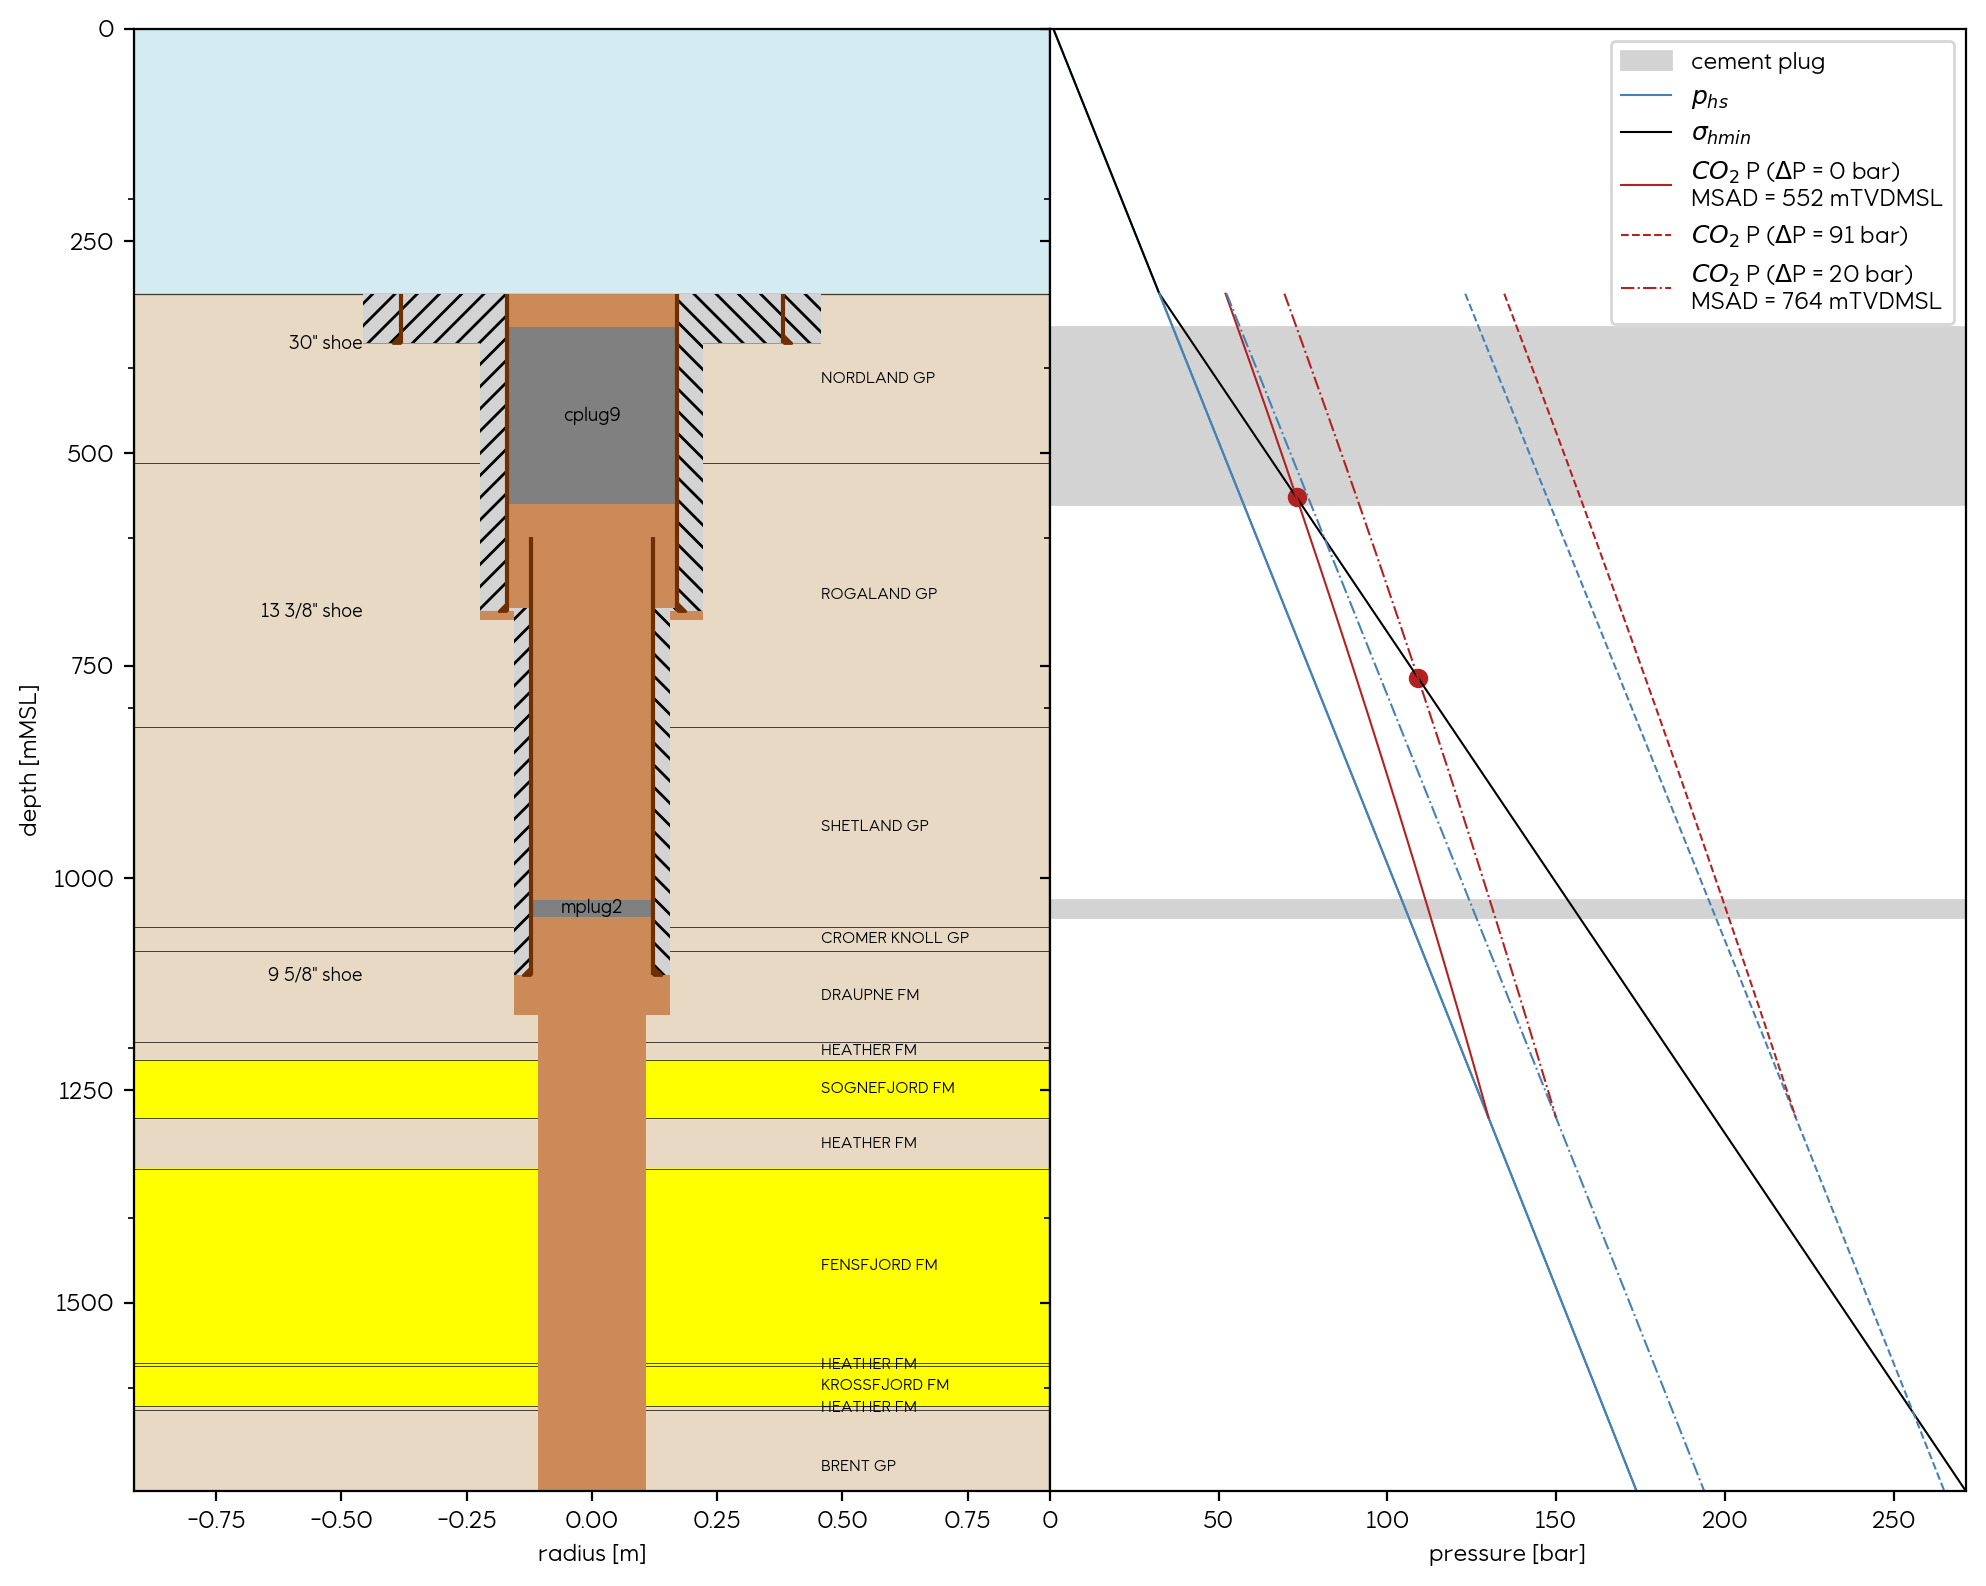

In [234]:
#Plot sketch, pressures
fig, (ax1, ax2) = plt.subplots(1,2, sharey=True, figsize=(10, 8))
plot_sketch(my_well, draw_open_hole=False, ax=ax1)
plot_pressure(my_pressure, my_well.geology, my_well.barriers, ax=ax2, 
              plot_HSP=True, #plot brine hydrostatic gradient
              plot_RP=True, #plot reservoir pressure scenarios
              plot_MSAD= True, #plot minimum safety abandonment depth
              plot_maxP=True #plot max expected pressures
              )

fig.tight_layout()
fig.subplots_adjust(wspace=0)


## Fecth info from well that will be used to define the vertical dimensions of the mesh

In [237]:
# Retrieve top reservoir depth
top_reservoir = well_df.geology_df.query('reservoir_flag == True')['top_msl'].min()

# Retrieve seafloor depth
top_overburden = my_well.header['sf_depth_msl']

# Define the thickness of the water column and the coarse overburden
water_column_thickness = top_overburden
coarse_overburden_thickness = (top_reservoir - top_overburden) - 5

# Define the thickness of the grid cells. 
tops_offset = 4
reservoir_cell_thickness = 5

grid_water_thickness = water_column_thickness - tops_offset
grid_coarse_thickness = (top_reservoir - top_overburden) - reservoir_cell_thickness #remove thickness of cap rock

#To make sure that no irrational numnbers are used we truncate the decimal places and add the residual to the top layer
cells_overburden_dz = grid_coarse_thickness // 9
cell_overbuden_dz_top = grid_coarse_thickness - (cells_overburden_dz * 8)

# Write the tops file
tops_file = include_dir / f'tops_dz.inc'

with open(tops_file, 'w') as f:
	f.write("EQUALS\n")
	f.write("TOPS 4 4* 1 1 /\n")
	f.write("/\n\n")
	f.write("DZ\n")
	f.write(f"400*{grid_water_thickness} 400*{cell_overbuden_dz_top} 3200*{cells_overburden_dz} 28000*{reservoir_cell_thickness} /\n")
	f.write("/\n")

## Update Equilibrium section

In [238]:
# Fetch values from Pressure and Well class to be included in the Equilibration section of *.in file
scenario_idx = 1
scenario_name = my_pressure.pressure_scenarios[scenario_idx]['name']

reservoir_wgc_d = my_well.co2_datum
reservoir_datum_d = reservoir_wgc_d
reservoir_pressure = np.interp(reservoir_wgc_d, my_pressure.pressure_CO2['init']['depth_msl'], my_pressure.pressure_CO2[scenario_name]['h2o'])

overburden_datum_d = 500
overburden_pressure = my_pressure.pressure_CO2['init'].loc[500]['hs_p']

In [239]:
# Define the temperature table
#Retrieve the temperature gradient and the surface temperature
sf_temp = my_well.header['sf_temp']
geo_tgrad = my_well.header['geo_tgrad']
sf_depth_msl = my_well.header['sf_depth_msl']

# Define the temperature table control points (top, seabed and bottom)
z_top_RTEMPVD = tops_offset
z_sf_RTEMPVD = top_overburden
z_bottom_RTEMPVD = grid_water_thickness + cell_overbuden_dz_top + (cells_overburden_dz * 8) + (reservoir_cell_thickness * 70) + tops_offset

# Define the deth column of the temperature table
z_RTEMPVT = np.linspace(z_sf_RTEMPVD, z_bottom_RTEMPVD, 8)
z_RTEMPVT = np.insert(z_RTEMPVT, 0, z_top_RTEMPVD)

# Calculate the temperature column
temp_RTEMPVT = sf_temp + (z_RTEMPVT-sf_depth_msl) * geo_tgrad/1000
temp_RTEMPVT[z_RTEMPVT <= sf_depth_msl] = sf_temp


# Create the RTEMPVD section string
new_rtempvd_section = "RTEMPVD\n    ! Metric\n"

for z, t in zip(z_RTEMPVT, temp_RTEMPVT):
	new_rtempvd_section += f"{z:11.2f} {t:8.2f}\n"



In [240]:
# Define the equilibration section of the input file

def setup_equilibration(name, d_datum, pressure, wgc_d, rtempvd, top, bottom):
	
  wgc_d_line = f"  WGC_D {wgc_d} m\n" if wgc_d is not None else ""
  
  equil_str = f"""
	
EQUILIBRATION {name}
  
  DATUM_D {d_datum} m
  PRESSURE {pressure:.2f} Bar	
  {wgc_d_line}
	
  TEMPERATURE_TABLE
    D_UNITS m !cannot be otherwise
    TEMPERATURE_UNITS C !cannot be otherwise
  
    {rtempvd}
	/  
  END

  SALT_TABLE
    D_UNITS m
    CONCENTRATION_UNITS MOLE
    SALTVD
      {top} 0.032
      {bottom} 0.032
    /
  END 
     
  GAS_IN_LIQUID_MOLE_FRACTION 0.0
/
	"""
  # Split the string into a list of lines and remove any leading/trailing whitespace on each line
  equil_lines = [line.rstrip() + '\n' for line in equil_str.strip().split('\n')]
  
  return equil_lines


equil_pmts = {
    'overburden_water': {
        'DATUM_D': overburden_datum_d,  
        'PRESSURE': overburden_pressure,  
        'WGC_D': None     
    },
    'CO2_column': {
        'DATUM_D': reservoir_datum_d,  
        'PRESSURE': reservoir_pressure,  
        'WGC_D': reservoir_wgc_d     
    }
}


with open(simcase.with_suffix('.in')) as file:
    lines = file.readlines()


new_lines = lines[:236]

for name, pmts in equil_pmts.items():
    
    equil_lines = setup_equilibration(name=name, pressure=pmts['PRESSURE'], d_datum = pmts['DATUM_D'], wgc_d= pmts['WGC_D'],  rtempvd=new_rtempvd_section, top=z_top_RTEMPVD, bottom=z_bottom_RTEMPVD)
    new_lines += equil_lines
    
new_lines += lines[316:]

with simcase.with_suffix('.in').open('w') as file:
    file.writelines(new_lines)


# Run coarse simulation

In [241]:
# file name (coarse grid) for pflotran run
run_config_coarse = simcase.with_suffix('.in')
run_config_coarse

PosixPath('../test_data/examples/wildcat-pflotran/model/ALPHA.in')

In [242]:
%%bash -s "$run_config_coarse"

runcirrus -i -nm 6 $1


bash -c <SCRIPT>



 Cirrus 1.9sv3
 Cirrus was compiled on: Jan 16 2025 15:50:13            
 RESERVOIR_DEFAULTS keyword selected.
 Cirrus card:: DIMENS                          
 Cirrus card:: EQUALS                          
 Cirrus card:: DZ                              
 Cirrus card:: EQUALS                          
 Cirrus card:: COPY                            
 Cirrus card:: MULTIPLY                        
 Cirrus card:: MINPV                           
 Calculating pore volumes
 Calculating connections
 Ncell=       32000  Nact=       32000  Nconn=       92400  Nflt=           0  Npo=           0
 Reading SUBSURFACE cards:
 Cirrus card:: GRID
 Cirrus card:: REFERENCE_PRESSURE
 Cirrus card:: REFERENCE_TEMPERATURE
 Cirrus card:: TIME
 Cirrus card:: OUTPUT
 Cirrus card:: NEWTON_SOLVER
 Cirrus card:: MATERIAL_PROPERTY
   Name :: formation
 "MATERIAL_PROPERTY,rock density units" set to default value.
 "MATERIAL_PROPERTY,specific heat units" set to default value.
 "MATERIAL_PROPERTY,dry thermal conduc

## Build LGR

In [243]:

##### LGR grid 
lgr = LGRBuilder(simcase, 
                 annulus_df, 
                 drilling_df,
                 Ali_way)

Coarse grid dimension: nx=20, ny=20, nz=80
Minimimum grid size is 5.00 cm
LGR dimension: nx=22, ny=22, nz=170


In [244]:
############### generate and output LGR #####################

LGR_NAME = f'LW_LGR'
output_dir = sim_path/'include'


# Write LGR file
gap_casing_df = lgr.build_grdecl(output_dir, 
                                 LGR_NAME,
                                 drilling_df,
                                 casings_df,
                                 barriers_mod_df)

gap_casing_df

...Prints isolating OVB from reservoir keywords in LW_LGR.grdecl file
...Prints CARFIN Keywords in LW_LGR.grdecl file
...Prints isolating OVB from reservoir in the LGR in LW_LGR.grdecl file
...reopenID = 8.50 ...
Output LGR CARFIN to:  /scratch/SCS/gpb/SCREEN/junk/SCREEN/test_data/examples/wildcat-pflotran/include/LW_LGR.grdecl


,top_rkb,bottom_rkb,diameter_in,toc_rkb,boc_rkb,shoe,cb_perm,diameter_m,top_msl,bottom_msl,toc_msl,boc_msl,n_grd_id,k_min,k_max,ij_min,ij_max,toc_k_min,toc_k_max
0,335.5,394.0,30.000,335.5,394.0,True,5,0.762000,312.0,370.5,312.0,370.5,14,10,15,4,17,10,15
1,335.5,709.0,13.375,335.5,709.0,True,5,0.339725,312.0,685.5,312.0,685.5,6,10,47,8,13,10,47
2,622.0,1137.5,9.625,706.0,1137.5,True,5,0.244475,598.5,1114.0,682.5,1114.0,4,38,90,9,12,47,90


At the moment the entire borehole without cement bond is assigned to EQLNUM = 2, which means that the entireborehole will be intitiated full of CO2. There is no method to script the top boundary of the EQLNUM so it has to be defined manually. For this case, we want to initialize the well full of CO2 up to the base of the main cement plug (cplug9). To do so we retrieve the `k_max` index and replace the grdecl. In the future this should be built in.

In [245]:
barriers_mod_df

,b_name,top_msl,bottom_msl,diameter_m,barrier_perm,n_grd_id,k_min,k_max,ij_min,ij_max
cplug9_0,cplug9,351.5,559.5,0.339725,0.5,6,14,34,8,13
mplug2_1,mplug2,1025.5,1045.5,0.244475,100.0,4,81,83,9,12


In [246]:
top_eql_k = barriers_mod_df.iloc[0]['k_max'] + 1
top_eql_k

35

In [247]:
with open((output_dir/LGR_NAME).with_suffix('.grdecl')) as lgr_file:
	lines = lgr_file.readlines()

for idx, line in enumerate(lines):
	

	if line.startswith('EQLNUM'):
		line_components = line.split()
		keyword, magnitude, i_min, i_max, j_min, j_max, k_min, k_max = line_components[:-1]
		magnitude, i_min, i_max, j_min, j_max, k_min, k_max = map(int, [magnitude, i_min, i_max, j_min, j_max, k_min, k_max])

		print(idx, magnitude,  k_min, k_max)
		if magnitude == 2 and (k_min < top_eql_k and k_max < top_eql_k):
			print(idx, line, 'op1')
			lines[idx] = f'--{line}'

		elif magnitude == 2 and k_min < top_eql_k:
			print(idx, line)
			lines[idx] = f'{keyword} {magnitude} {i_min} {i_max} {j_min} {j_max} {top_eql_k} {k_max} /\n'
		


with (output_dir/LGR_NAME).with_suffix('.grdecl').open('w') as file:
    file.writelines(lines)	



35 2 11 16
35 EQLNUM  2  5  18  5  18  11  16  /
 op1
52 2 11 48
52 EQLNUM  2  9  14  9  14  11  48  /

69 2 39 96
84 2 49 96
94 2 96 170
104 1 11 17
112 1 11 17
120 1 11 17
127 1 11 17
137 1 11 17
145 1 11 17
153 1 11 17
160 1 11 17
170 1 17 48
178 1 17 48
186 1 17 48
193 1 17 48
203 1 48 49
211 1 48 49
219 1 48 49
226 1 48 49
236 1 49 91
244 1 49 91
252 1 49 91
259 1 49 91


# Run LGR simulation

In [248]:
# Update the grdecl file
with open(simcase_grdecl) as file:
    lines = file.readlines()

# Add the include file line so it reads the generated LGR file
lines[5] = f'external_file ../include/{LGR_NAME}.grdecl / \n'

with simcase_grdecl.open('w') as file:
    file.writelines(lines)


In [249]:
#Update the *.in file
with open(simcase.with_suffix('.in')) as file:
    lines = file.readlines()


# start_date = datetime(2025,1,1)
# end_date = datetime(2025,1,1+1)
# title = 'LEGACY Well experiment - SCREEN simulation'

# lines[1] = f'!{title}\n'
# lines[34] = f' START_DATE  {start_date.strftime("%d %b %Y").upper()}\n'
lines[35] = f' FINAL_DATE  {end_date.strftime("%d %b %Y").upper()} \n'
# lines[23] = f'  TYPE grdecl ../include/{simcase_grdecl.name} \n'






with simcase.with_suffix('.in').open('w') as file:
    file.writelines(lines)


In [250]:
# file name (LGR grid) for pflotran run
run_config_lgr = simcase.with_suffix('.in')
run_config_lgr

PosixPath('../test_data/examples/wildcat-pflotran/model/ALPHA.in')

In [251]:
%%bash -s "$run_config_lgr"

runcirrus -i -nm 6 $1


bash -c <SCRIPT>



 Cirrus 1.9sv3
 Cirrus was compiled on: Jan 16 2025 15:50:13            
 RESERVOIR_DEFAULTS keyword selected.
 Cirrus card:: DIMENS                          
 Cirrus card:: EQUALS                          
 Cirrus card:: CARFIN                          
 Cirrus card:: NXFIN                           
 Cirrus card:: NYFIN                           
 Cirrus card:: NZFIN                           
 Cirrus card:: HXFIN                           
 Cirrus card:: HYFIN                           
 Cirrus card:: EQUALS                          
 Cirrus card:: EQUALS                          
 Cirrus card:: EQUALS                          
 Cirrus card:: EQUALS                          
 Cirrus card:: EQUALS                          
 Cirrus card:: EQUALS                          
 Cirrus card:: EQUALS                          
 Cirrus card:: EQUALS                          
 Cirrus card:: EQUALS                          
 Cirrus card:: EQUALS                          
 Cirrus card:: EQUALS    

### Load files from pflotran simulation

In [252]:
# load LGR grid from simulation file
grid_lgr = GridLGR(simcase)

In [253]:
grid_lgr.lgr_index

,i,j,k,active,PORV,DX,DY,DZ,PERMX,PERMY,PERMZ,MULTX,MULTY,MULTZ,MULTX-,MULTY-,MULTZ-,TRANX,TRANY,TRANZ,PORO,DEPTH,NTG,SATNUM,EQLNUM,FIPLEG
0,0,0,0,0,259171.781250,91.731499,91.731499,30.799999,10000.0,10000.0,1000.0,1.0,1.0,1.0,1.0,1.0,1.0,4.865965e+03,4865.965332,2329.610840,1.0,19.4,1.0,1,1,1
1,1,0,0,1,20595.244141,7.289500,91.731499,30.799999,10000.0,10000.0,1000.0,1.0,1.0,1.0,1.0,1.0,1.0,6.123566e+04,386.676941,185.123962,1.0,19.4,1.0,1,1,1
2,2,0,0,2,1635.866211,0.579000,91.731499,30.799999,10000.0,10000.0,1000.0,1.0,1.0,1.0,1.0,1.0,1.0,7.660298e+05,30.713484,14.704269,1.0,19.4,1.0,1,1,1
3,3,0,0,3,141.266510,0.050000,91.731499,30.799999,10000.0,10000.0,1000.0,1.0,1.0,1.0,1.0,1.0,1.0,4.818328e+06,2.652287,1.269799,1.0,19.4,1.0,1,1,1
4,4,0,0,4,141.266510,0.050000,91.731499,30.799999,10000.0,10000.0,1000.0,1.0,1.0,1.0,1.0,1.0,1.0,4.818328e+06,2.652287,1.269799,1.0,19.4,1.0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82275,17,21,169,82275,4.586575,0.050000,91.731499,5.000000,1000.0,1000.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,7.821960e+04,0.000000,0.000000,0.2,1557.0,1.0,1,2,4
82276,18,21,169,82276,4.586575,0.050000,91.731499,5.000000,1000.0,1000.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,1.243555e+04,0.000000,0.000000,0.2,1557.0,1.0,1,2,4
82277,19,21,169,82277,53.112537,0.579000,91.731499,5.000000,1000.0,1000.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,9.940853e+02,0.000000,0.000000,0.2,1557.0,1.0,1,2,4
82278,20,21,169,82278,668.676758,7.289500,91.731499,5.000000,1000.0,1000.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,7.899294e+01,0.000000,0.000000,0.2,1557.0,1.0,1,2,4


# Visualization

In [254]:
import inspect
inspect.getfile(plot_grid)

'/scratch/SCS/gpb/SCREEN/junk/SCREEN/src/WellClass/libs/plotting/plot_grids.py'

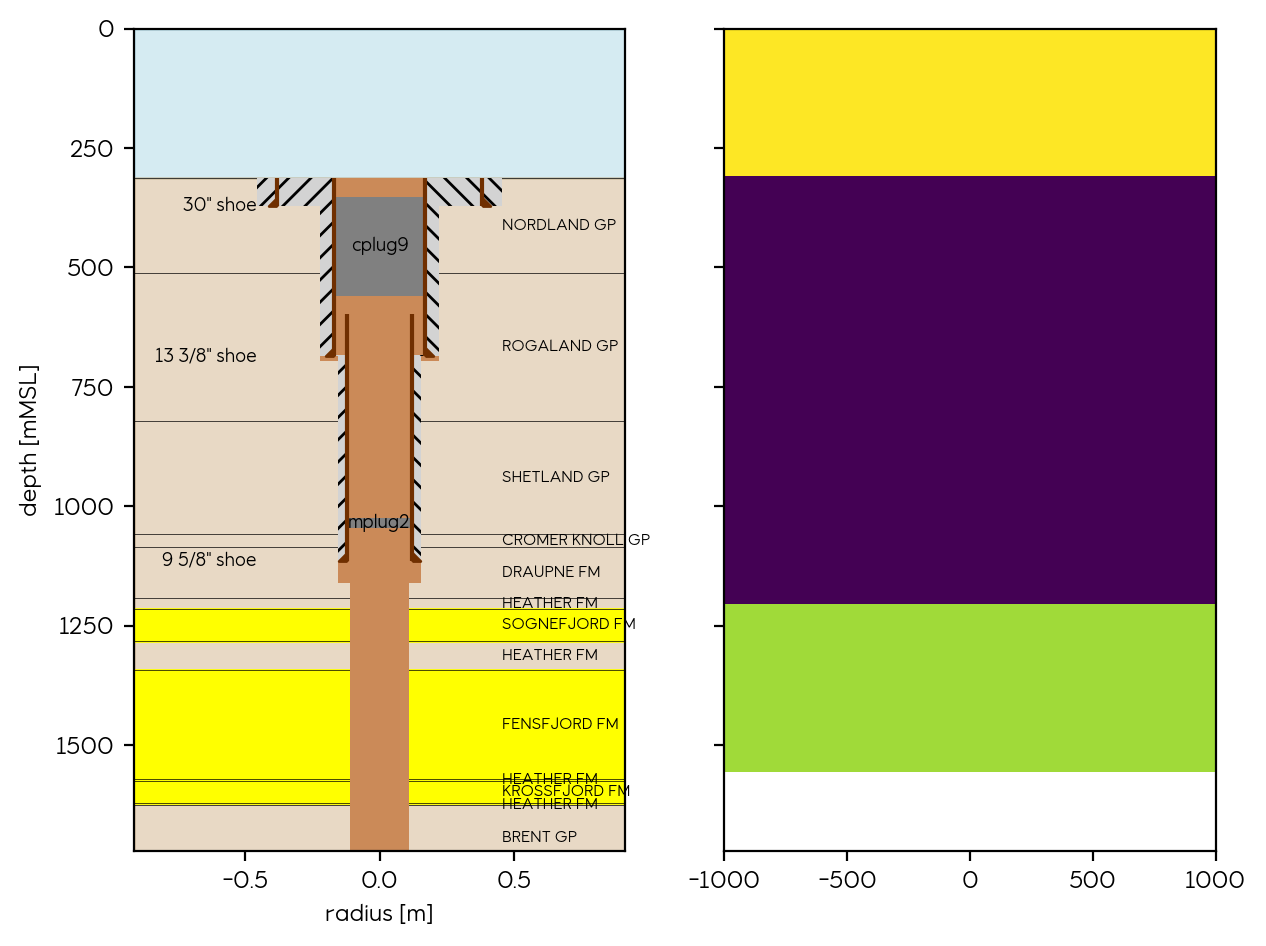

[]

In [255]:
# coarse grid
grid_coarse = lgr.grid_coarse

plot_grid(my_well, grid_coarse, prop='PERMX', )

import matplotlib.pyplot as plt

plt.get_fignums()

In [256]:
import matplotlib.pyplot as plt

# Retrieve a list of all active figures
figures = [plt.figure(num) for num in plt.get_fignums()]

# Display the figures
for fig in figures:
    fig.show()

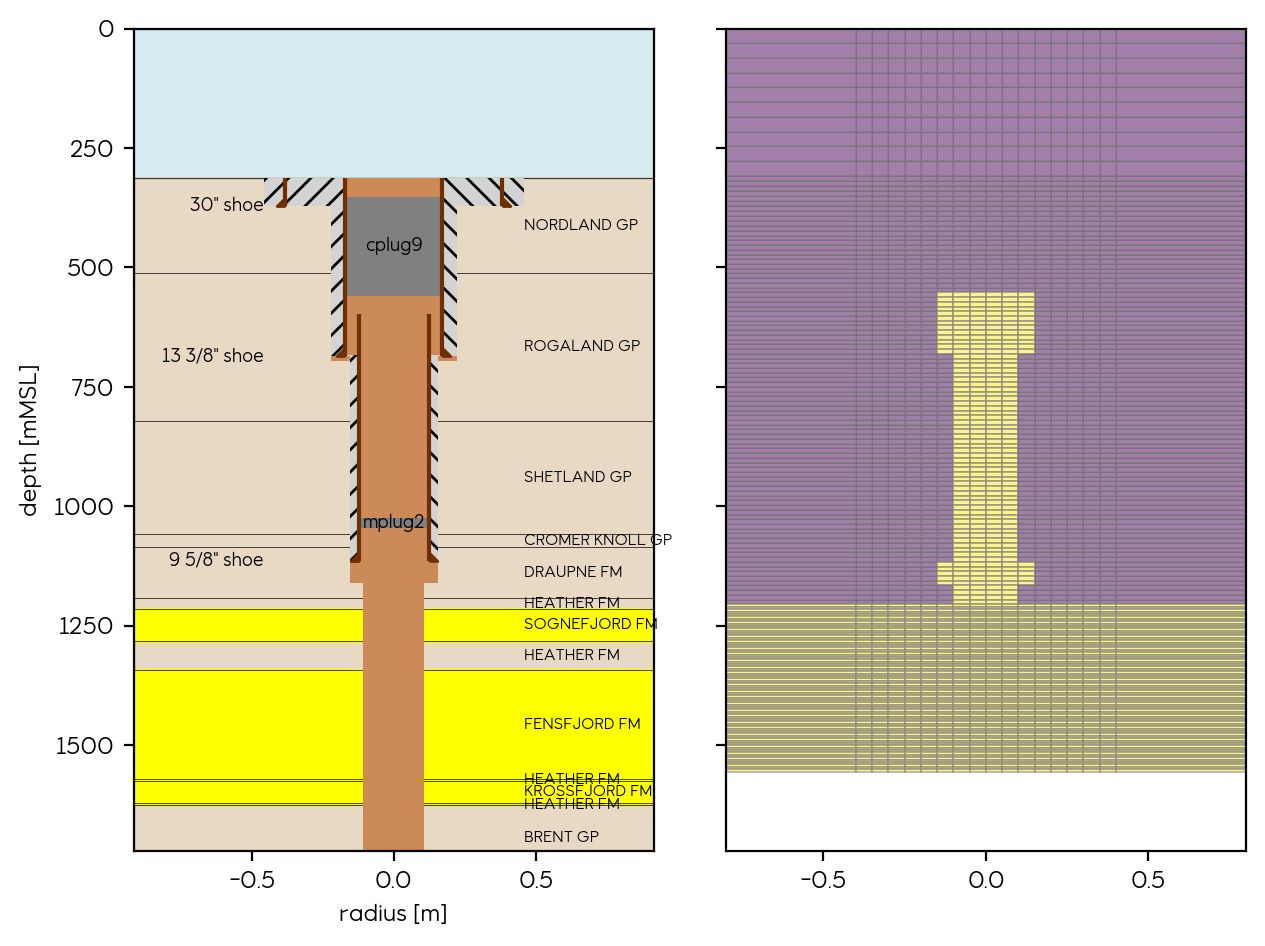

In [257]:
# LGR grid from pflotran output
PROPS = 'TRANZ'
PROPS = 'PERMX'
PROPS = 'EQLNUM'
# plot it
plot_grid(my_well, grid_lgr, prop=PROPS)

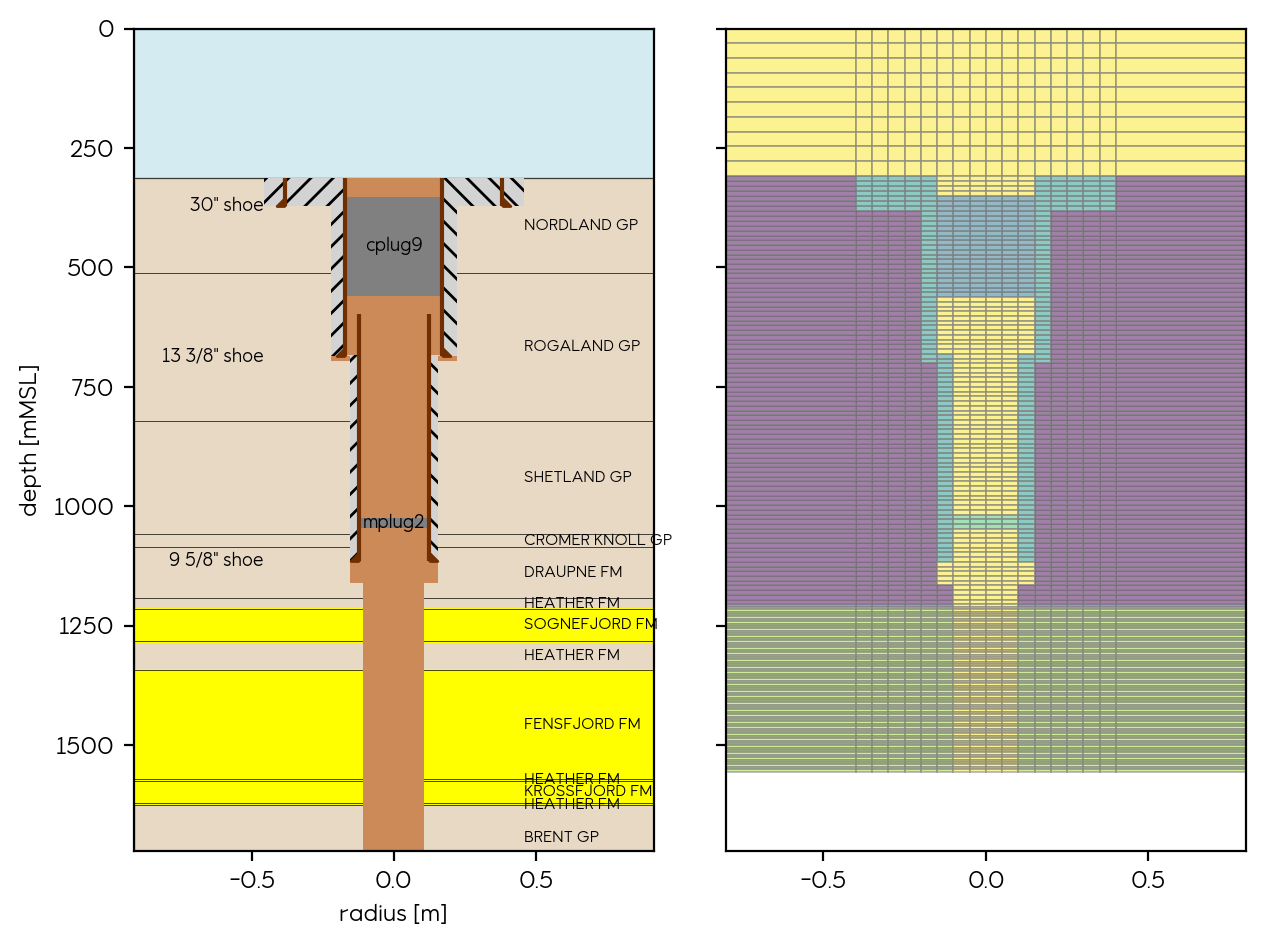

In [66]:
# LGR grid from dataframe
grid_refine = lgr.grid_refine

plot_grid(my_well, grid_refine)

# Other Qcs

In [ ]:
# testing plot_sketch
DEBUGGING = True
if DEBUGGING:
    from src.WellClass.libs.plotting import plot_sketch
    plot_sketch(my_well, 
                draw_annotation=False,
                draw_open_hole=True,
                draw_cement_bond=False,
                draw_casings=False, 
                draw_barriers=False)

In [29]:
ip_grid = grid_refine.mesh_df.sort_values(by=["k","j","i"])

In [ ]:
type(ip_grid)

In [31]:
# lgr mesh from simulation file
lgr_index = grid_lgr.lgr_index

In [ ]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
prop = 'PERMX'
ax.scatter(ip_grid[prop], lgr_index[prop])
ax.set_xlabel(f'{prop} in grid.refine')
ax.set_ylabel(f'{prop} in grdecl')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, lw=0.5, ls='--')

In [ ]:
fig, ax = plt.subplots()
prop = 'DX'
ax.scatter(ip_grid[prop], lgr_index[prop])
ax.set_xlabel(f'{prop} in grid.refine')
ax.set_ylabel(f'{prop} in grdecl')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, lw=0.5, ls='--')

In [ ]:
fig, ax = plt.subplots()
prop = 'DZ'
ax.scatter(ip_grid[prop], lgr_index[prop])
ax.set_xlabel(f'{prop} in grid.refine')
ax.set_ylabel(f'{prop} in grdecl')
ax.plot([0, 1], [0, 1], transform=ax.transAxes, lw=0.5, ls='--')